# Getting started : Information about Jupyter

*Course: Data Mining*<br><br>

*Pair:*
 
 - Emmanuel Daveau - Contact: emmanuel.daveau.auditeur@lecnam.net<br>
 
*Master MEDAS - CNAM Nantes*

#### Prerequisites:

This project aims at analyzing tweets from the 11 candidates to the French presidential election in 2017. This document has been created using Jupyter (a Python Markdown interface) with Python 3.7.3. There are a few things you need to do before running this script:

-  __Installing Jupyter__ : Preferably, please download and install the Anaconda distribution on [anaconda.com](https://www.anaconda.com/distribution/)

-  __Update all Python packages__ : To do so, please Run Anaconda Prompt (on Windows : Start, All Programs, Anaconda, Anaconda Prompt), then run the following command : `conda update --all`, and type "y".

-  __Install some Python packages__ : For this, run `pip install [package_name]`. For now, the `nbprogress`  , `stop_words` ,  `spacy`  and `unidecode`  packages are needed. For the lemmatizer, `spacy`'s French core module can be downloaded with `python -m spacy download fr_core_news_sm`

-  __Get the data working__ : Save this .ipynb file in a directory on your computer. Then create a "data" subdirectory in the same directory the Jupyter file is in. You can then save the data file (which you can [download here](https://www.ortolang.fr/market/corpora/corpus-presidentielle2017)) in the "data" directory. Please rename the xml file *"presidentielle2017.xml"*. The last file you will need is the *"Lexique382.tsv"* file in the data directory. This is our lemmas dictionary which can be [downloaded on lexique.org](http://www.lexique.org/).

Doing this will ensure there are no problems running the file.

The installation of the packages can be completed running the cell below. As it is optional, you'll need to remove the "#" at the beginning to run it in Jupyter Notebook.

In [1]:
#!pip install nbprogress
#!pip install stop_words
#!pip install spacy
#!pip install unidecode
#!python -m spacy download fr_core_news_sm

In [1]:
import datetime as dt
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nbprogress
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import spacy
import xml.etree.ElementTree as ET

from collections import Counter, defaultdict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import NearMiss
from medaspack import modulemedas as mm
from medaspack.modulemedas import dict_of_candidates
from nltk.tokenize import word_tokenize
from scipy.stats import pearsonr
from scipy import sparse
from sklearn import svm, metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.manifold import MDS
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from stop_words import get_stop_words
from yellowbrick.text import TSNEVisualizer

nlp = spacy.load("fr_core_news_sm", disable = "sentencizer")

# Data extraction

## Getting familiarized with the data

First, we need to open the file "presidentielle2017.xml" in Jupyter. If you don't have it, please remember to download it [here](https://www.ortolang.fr/market/corpora/corpus-presidentielle2017). The following block uses the `parse` function from the ElementTree module in the `xml` library to read the file.

In [2]:
xmlTree = ET.parse('data/presidentielle2017.xml')
xmlTree.getroot()

<Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x000000001E2D4728>

The output above should display something like : *`Element '{http://www.tei-c.org/ns/1.0}TEI' at 0x0000000016BBFC28>`*.<br>

This means the file was successfully parsed into an ["ElementTree" class](https://docs.python.org/2/library/xml.etree.elementtree.html#xml.etree.ElementTree.ElementTree). Now we have parsed it, we can start by extracting all the HTML `<tags>` contained within the document :

In [3]:
elemList = []

#for each element in xmlTree, append it to a list, then make a set of unique elements
for elem in xmlTree.iter():
  elemList.append(elem.tag)
elemList = sorted(list(set(elemList)), key=str.lower)

tagList = [s.replace("{http://www.tei-c.org/ns/1.0}", "") for s in elemList]
print("There are", len(tagList), "tags in the TEI file.\n\n", " - ".join(tagList))

There are 94 tags in the TEI file.

 addName - addressee - addressingTerm - addressMarker - att - author - availability - bibl - binary - body - catDesc - category - channel - classDecl - constitution - country - creation - date - derivation - desc - distinct - domain - editorialDecl - email - encodingDesc - extent - f - factuality - fDecl - fDescr - fileDesc - fs - fsdDecl - fsDecl - geogName - gi - ident - idno - interaction - item - keywords - language - langUsage - licence - list - listPerson - location - name - namespace - normalization - note - numeric - orgName - p - particDesc - persName - person - placeName - post - preparedness - principal - profileDesc - projectDesc - publicationStmt - publisher - purpose - quote - ref - resp - respStmt - rs - segmentation - seriesStmt - sourceDesc - sponsor - string - surname - tagsDecl - tagUsage - taxonomy - TEI - teiHeader - term - text - textClass - textDesc - title - titleStmt - trailer - val - vAlt - vDefault - vNot - vRange


Overall, there are 94 tags within the xml file. However, among these tags, 77 contain information which is not relevant to this project (eg. Information about the authors and founders of the data file...). More details about these tags are given in the [tags_desc_str](https://github.com/edaveau/DataMiningCNAM/blob/master/tags_desc_str.txt) file.

Briefly said, the raw data file is divided in two parts :

-  The __header__ : Which contains all the information about the document itself *(language used, authors of the document, contact information...)*

- The __body__ : Contains all the tweets.
Therefore, we will create a variable which will address the data contained in this specific tag only.

In [4]:
#define the variable body as the position for the body tag
root = xmlTree.getroot()
body = root[1][0]
print(body.tag)

{http://www.tei-c.org/ns/1.0}body


Now that we have selected our *body*, we can loop over it to see what tags are left among the 94 described above.

In [5]:
elemList = []

#retain all elements in our body, then make a set of unique elements
for elem in body.iter():
    elemList.append(elem.tag)
elemList = sorted(list(set(elemList)), key=str.lower)

tagList = [s.replace("{http://www.tei-c.org/ns/1.0}", "") for s in elemList]
print("There are ", len(tagList), " tags in the body of the file.\n\n", " - ".join(tagList))

There are  16  tags in the body of the file.

 addressee - addressingTerm - addressMarker - binary - body - distinct - f - fs - ident - numeric - p - post - ref - rs - string - trailer


All these tags follow a specific structure, which is described in [this document](https://github.com/edaveau/DataMiningCNAM/blob/master/tweets_struct.xml). Thus, we need to be careful to respect it when retrieving the data about the global architecture of the file, so we do not encounter any errors / miss any data. <br>

&emsp;&emsp;The following loop displays the first 5 tweets of Nathalie Arthaud as an example. Mostly, it shows the global structure to loop over the information contained within the ElementTree and retrieves all the tweets from a specific candidate.

In [7]:
hashtag = ""
addressee = ""
text = ""
tweet = ""
tweet_count = 0

for twText in body.findall('.//*[@who="#cmr-présidentielle-p1003575248"]/{http://www.tei-c.org/ns/1.0}p'):
    for twDist in twText.findall('{http://www.tei-c.org/ns/1.0}distinct'):
        for twHash in twDist.findall('{http://www.tei-c.org/ns/1.0}ident'):
            hashtag=twHash.text
        for twHashWord in twDist.findall('{http://www.tei-c.org/ns/1.0}rs'):
            hashtag = hashtag+twHashWord.text
    for addTerm in twText.findall('{http://www.tei-c.org/ns/1.0}distinct'):
        for addMark in addTerm.findall('{http://www.tei-c.org/ns/1.0}addressMarker'):
            addressee = addMark.text
        for addName in addTerm.findall('{http://www.tei-c.org/ns/1.0}addressee'):
            addressee = addressee + addName.text
    text = "".join(twText.itertext())
    tweet = text+hashtag+addressee
    print(tweet)
    if tweet_count < 5 :
        tweet_count = tweet_count + 1
    else :
        break


Vestes réversibles https://t.co/KdZXncEsv5

Un monde à changer https://t.co/yRg0eGCIUJ

Tempête dans un verre d’eau bénite ? https://t.co/aGw9iGHMek

#10mai
Commemoration fin de l esclavage. Reste à supprimer l esclavage salarial defendu par #Macron
et Hollande #Macron

RT
@LutteOuvriere
:
[Éditorial] #Macron
président : les travailleurs devront se défendre par eux-mêmes ! https://t.co/lVT88faGlV#Macron

Après le deuxième tour de l’élection présidentielle 2017 |  https://t.co/BbBSd3atkX#Macron


Using the same logic, we can also print a list of all the hashtags used in the first 100 tweets written by Nathalie Arthaud.

In [8]:
liste = []
tag_count = 0

for twText in body.findall('.//*[@who="#cmr-présidentielle-p1003575248"]/{http://www.tei-c.org/ns/1.0}p/{http://www.tei-c.org/ns/1.0}distinct/{http://www.tei-c.org/ns/1.0}rs'):
    liste.append("#"+twText.text)
    if tag_count < 100 :
        tag_count = tag_count + 1
    else :
        break
       
print(" - ".join(sorted(list(set(liste)))))

#10mai - #15MinutesPourConvaincre - #15Mpc - #15minutesPourConvaincre - #1Mai - #1mai - #2017LeDebat - #2017LeDébat - #CGT - #Conforama - #Ecole - #Engie - #FN - #Franc - #G… - #Le - #LePen - #LePen, - #LePen 
#Macron, - #Lepen - #Macron - #Macron, - #Macron: - #Manifestation - #Mélenchon - #Presidentielle2017 - #Sudradio - #TDInfos - #Tati, - #WhirlpoolAmiens - #amiante - #blanc - #capitalisme - #champselysees - #c… - #debat2017 - #dieselgate - #euro - #jihadistes - #macron - #migrants - #patrons - #révolutions - #sudradio - #terrorisme - #terroristes - #whirlpool


##  Accessing each element we will use

&emsp;&emsp;Now, we can start retrieving the data. But it can be a good idea to see how to access each element we want to retrieve individually first. For instance, how does one access a tweet id? To make the code cleaner, we'll create a *"namespace"* dictionary, so we don't have to write the namespace everywhere in our code. Indeed, the latter can quickly make the code too heavy to read properly. Namespaces are the elements which look like `{http://www.tei-c.org/ns/1.0}` before the elements tags. More information about namespaces are given on [this website](http://www.xmlmaster.org/en/article/d01/c10/).<br>
&emsp;&emsp;Furthermore, you may notice that the structure of the tweets (first code block below) is different from the structure of the retweets (second code block below). That is why we will have to be careful when retrieving our data so we do not mix up tweets and retweets. <br>
&emsp;&emsp;Finally, another important thing to keep in mind is that when tweets or retweets are not liked or retweeted by anyone, the "favoritecount" and "retweetcount" do not appear in the xml file (*instead of being set to 0 for instance*). Therefore, we will need to keep that in mind when retrieving the data.

In [8]:
mm.display_random_tweet(body)

A tweet was written by: Benoit Hamon,
had the following id: cmr-présidentielle-a828192916875145216,
was written on this date: 2017-02-05T11:45:53.0,
via: Twitter for iPhone,
It received 369 favourites and 281 RTs,
And the text was:  #Mutualité @CageJulia "Le #RevenuUniversel donne plus d'autonomie aux jeunes, de liberté à toutes et tous et, ainsi… https://t.co/AoVsZzdXYz


In [9]:
mm.display_random_retweet(body)

A retweet was written by: François Fillon,
had the following id: cmr-présidentielle-a799373464528420864,
was written on this date: 2016-11-17T23:07:40.0,
via: Twitter Web Client,
it had: 191RTs,
and the text was :  RT @Fillon2017_fr : Faux, Monsieur Juppé: - F. Fillon veut supprimer 500.000 postes, non 600.000 - il intègre les contractuels, pas seulemen… 


&emsp;&emsp;Great! We managed to access all the relevant information we want to retrieve. Now we simply need to combine both scripts into one that will differentiate between tweets and retweets, and which appends all this information into a list of dictionaries. Therefore, each dictionary of the list will be a post (or tweet) with all its information (*the equivalent to a table's row*, and each dictionary key will correspond to a variable we are interested in (*the equivalent to a table's column*).

## Creating the dataset

As said, the main task we will have to do here is to create a loop which will gather all the information we need, which are for instance:

| tweet_id     | tweet_author |  tweet_date  |    medium    |  fav_count   |   rt_count   |  is_retweet  |     text     |
|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
| *a862338397* | *p102722347* | *2017-05-10* |   *iPhone*   |     *71*     |     *12*     |    *True*    |*Hello World!*|

&emsp;&emsp;The bar above should be green and show that 42 923 posts were processed into a list of dictionaries. However, we can also make a final checkup to ensure we retrieved all information correctly, that is, counting the number of posts in the XML file and comparing it with the number of elements in our list of dictionaries. If the loop worked correctly, we should have the same length in both.

In [11]:
count = 0
list_length = len(list_of_dict)

for post in body:
    count = count+1

print("There are", count, "posts in the original XML file.\nThere are", 
      list_length, "elements in the converted list of dictionaries")

There are 42923 posts in the original XML file.
There are 42923 elements in the converted list of dictionaries


We can also display a random tweet in our list of dictionaries:

In [12]:
mm.print_tweet(list_of_dict)

The following tweet is the tweet number 35267 



{'twID': 'cmr-présidentielle-a679289468038328320',
 'twAuthor': 'François Asselineau',
 'twDate': '2015-12-22T14:16:44.0',
 'twMedium': 'Twitter for iPhone',
 'nFav': None,
 'nRT': '71',
 'isRT': True,
 'twText': ' RT @RTenfrancais : #Oman: quand les USA censurent un rapport sur les droits de l’homme pour protéger leur allié https://t.co/f7LBkYUzvnhttp… '}

We now have the confirmation we successfully converted the XML file into a list of dictionaries. Doing so, we correctly retrieved all 42 923 tweets collected by the laboratories AGORA and ETIS at the Université de Cergy-Pontoise. 

&emsp;&emsp;However, there is one thing we should pay attention to. The original data file said they collected 44 979 tweets, and each tweet is identified by the `<post/>`  tags. But when we simply counted the number of <post/> tags, we only found 42 923 posts. We decided to investigate this concern further, and therefore we contacted Mr. Julien Longhi about it. He replied to us that the number of tweets we measured was accurate, and that he did not understand why the #idéo2017 interface displayed 44979 tweets. 
Therefore, we can continue our analysis while being sure we gathered all the data collected by Mr. Longhi's team.

The primary step was to convert the data from the XML file to a format Python can easily and efficiently work with, that is, a list of dictionaries. The second step of this project is to pre-process the data in order to have clean and  usable. The main steps of data preprocessing in text mining are the cleaning of our features and making our text exploitable by machine learning algorithms.

### 4) Cleaning raw data

The first modifications we can apply to our data are the following:

-  Modify the date to follow a standard format %Y-%m-%d %H:%M:%S

-  Remove the "Twitter for" string in the twMedium key

-  Add a key corresponding to each candidate's party

The following tweet is the tweet number 33008 



{'twID': 'cmr-présidentielle-a717621048682921984',
 'twAuthor': 'Jacques Cheminade',
 'twDate': datetime.datetime(2016, 4, 6, 9, 52, 45),
 'twMedium': 'TweetDeck',
 'nFav': None,
 'nRT': '4',
 'isRT': True,
 'twParty': 'Solidarité et Progrès',
 'twText': " RT @SetP_officiel : Mercredi 6 avril, conférence de Jacques #Cheminade à l'IESEG de #Lille #hautsdefrance https://t.co/6GZYAolfgi"}

## Preprocessing data

Now that we have a cleaner list of dictionaries, the main task will consist in processing the raw text of the tweets. We noted 5 main tasks we'll have to complete in order to be able to work on bags of words:

*  Remove __uppercase__

*  Remove the __URLs__

*  Remove all __special characters__ (emojis, hashes, at signs...) excepted for percentages which we would like to keep for now

*  Remove all the __numbers at the beginning or at the end of the tweets__, as these often imply on Twitter that the author wrote a thread, and numbers the amount of tweets he wrote for this thread.

*  __Tokenize__ the sentences

*  Remove all __stopwords__ such as *le, la, les, un...*

*  __Lemmatize__ the words

At this point, we should also remove diacritical marks. However, lots of dictionaries (eg. stop-words or lemmas) use these diacritical marks to decide what type of word each word is. Therefore, we will probably remove it later, or just refer to the general lemmatized version of each word.

The following tweet is the tweet number 14182 



{'twID': 'cmr-présidentielle-a840157341160996864',
 'twAuthor': 'François Asselineau',
 'twDate': datetime.datetime(2017, 3, 10, 12, 8, 14),
 'twMedium': 'Twitter Web Client',
 'nFav': '195',
 'nRT': '178',
 'isRT': False,
 'twParty': 'Union Populaire Républicaine',
 'twText': ' François Asselineau : "C\'est une honte de vouloir détruire les services publics" #Asselineau2017 #frexit #asselineaupresident ',
 'cleanText': ' françois asselineau c est une honte de vouloir détruire les services publics asselineau2017 frexit asselineaupresident '}

## Lemmatizing sentences

We commented this part as it takes a few minutes to complete when run. However, what it does it quite simple. It lemmatizes each word in each tweet and then returns each word as a lemma in a separate column.

In [ ]:
#nlp = spacy.load("fr_core_news_sm", disable = "sentencizer")
#
#for tweet in nbprogress.log(data, every = 100):
#    tweet["lemmas"] = nlp(tweet["twText"])
#    tweet["lemmas"] = " ".join([token.lemma_ for token in tweet["lemmas"]])
#    
#mm.print_tweet(data)

# Candidates' Stylistic analysis

This part aims at analyzing the style of the tweets of each candidate.

We will begin by analyzing the volume of tweets and retweets by author in order to better understand their use of Twitter.

We will then study the number of total words per candidate to evaluate those who have communicated the most, as well as the average number of words per tweet and per candidate. We will then be able to identify more or less concise authors.

We will then study the diversity of vocabulary of the candidates, by counting the unique words used by each of them, in absolute value to begin, then in relative value compared with the totality of the words they used.

Finally, we will observe the frequency of appearance of the 30 most used words by all the candidates, then the usual distribution of its thirty lemmatized msot used words to refine the study. In this way, we will be able to begin to highlight the most discussed themes.

In [3]:
with open("data/data_v0_2_lemma_on_text.json") as json_file:
    data = json.load(json_file)

## Number of tweets and retweets by author

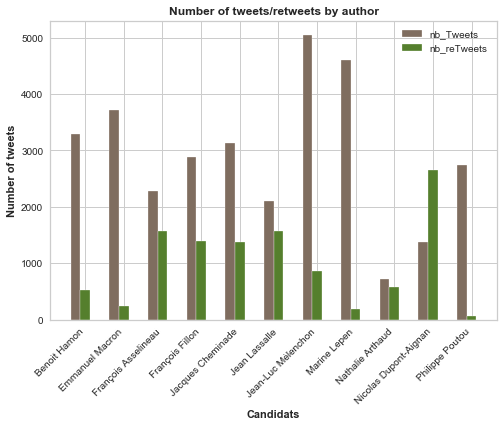

__Tweets / retweets distribution__

We can see with the distribution of tweets / retweets that candidates do not all have the same use of Twitter. Some use it mainly to communicate their own ideas, retweeting very rarely. We can mention Marine Lepen, Emmanuel Macron, Philippe Poutou, Benoit Hamon and Jean-Luc Mélenchon.

Others have a more balanced use, with a majority of tweets in their online activity, but with an almost equal share of retweets. This is the case of François Asselineau, François Fillon, Jacques Cheminade, Jean Lassalle and Nathalie Arthaud.

Finally, making exception with a number of retweeets much higher than his tweets, Nicolas Dupont-Aignan uses Twitter more often to react to ideas ideas of others than to communicate his own ideas.

__Analysis of the number of tweets__

We are now going and for the rest of the study focus on tweets only, the retweets were not written by the candidates and therefore are not representative of their style. The number of tweets can be divided into three slices to facilitate analysis: 0-2000 tweets, 2000-4000 tweets, more than 4000.

The 0-2000 tweets segment represents the candidates tweeting the least, where we find Nathalie Arthaud and Nicolas Dupond-Aignan. The first has a relatively limited activity on his Twitter account compared to the other candidates, both in tweets and retweets. The second is in this category because he uses more retweets than tweets.

In 2000-4000 tweets we find the majority of candidates, this slice of activity seems to represent a standard volume of activity on Twitter for a candidate. This slice includes Emmanuel Macron, Philippe Poutou, Benoit Hamon, François Asselineau, François Fillon, Jacques Cheminade and Jean Lassalle. Finally, in the more than 4000 tweets section, we find the two most active candidates, Jean-Luc Mélenchon and Marine Lepen.

__Density of communication of the candidates__

To count the words used by the candidates, we filtered the retweets to eliminate them in order to take only the elements written by the candidates in account. We then transform into 'tokens' all the words used in order to count them.

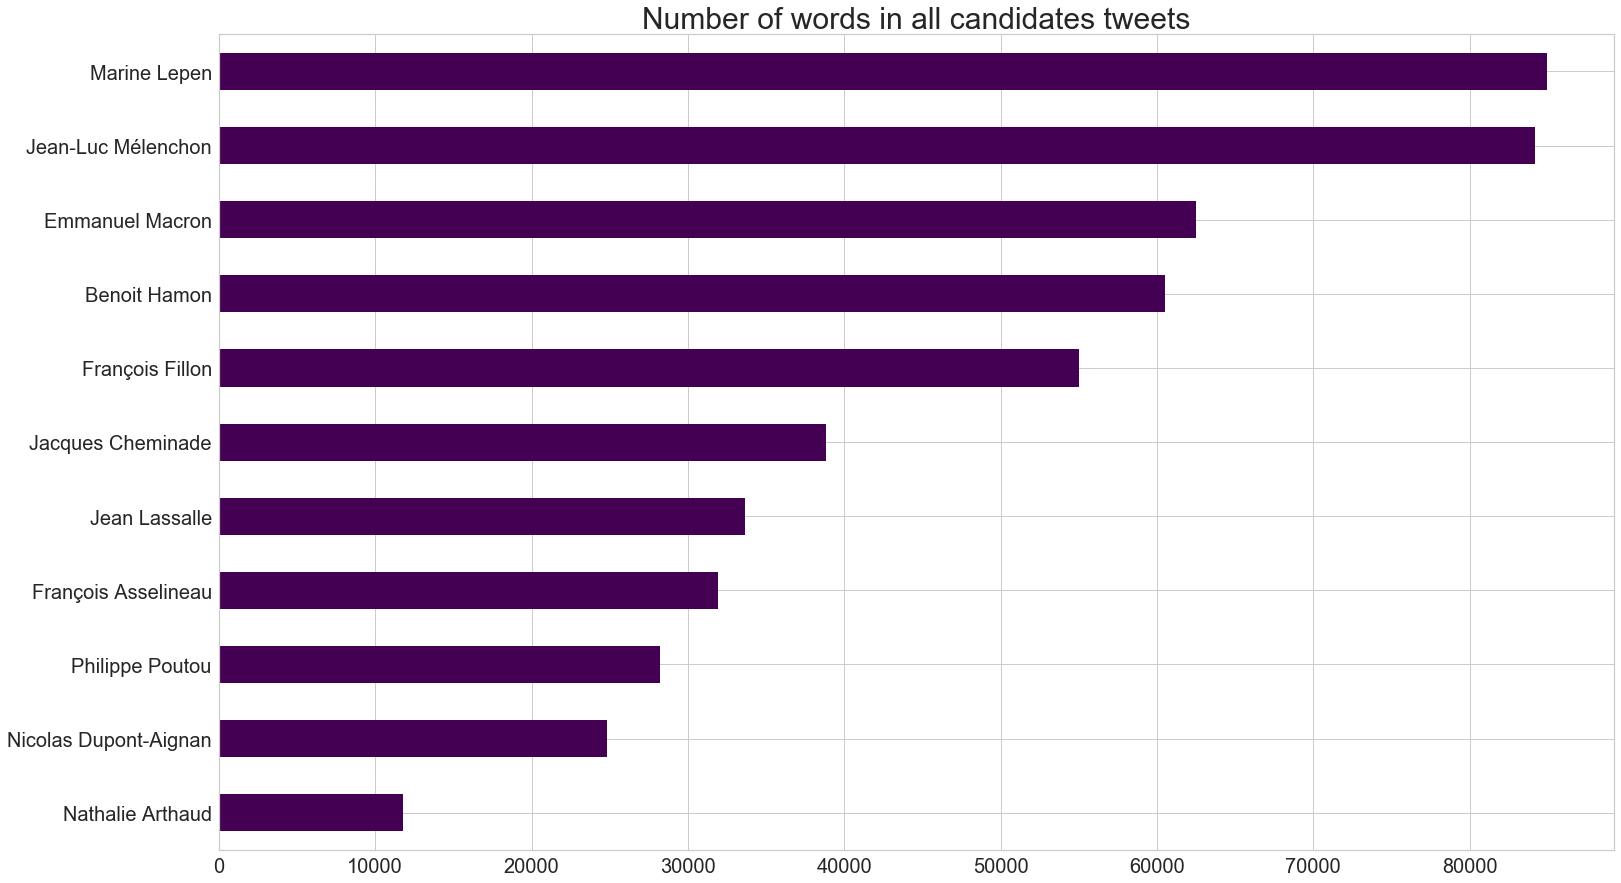

We can now analyze the number of words written by the candidates, more representative than the number of tweets to study the total volume of information they have published.

Nathalie Arthaud is the least prolific, with just over 10,000 words written.<br>

One can find in a second group with between 20,000 and 40,000 words: Philippe Poutou, François Asselineau, Jacques Cheminade, Nicolas Dupond-Aignan and Jean Lassalle.<br>

Then there is a third group of candidates with between 50,000 and 65,000 words written: Françoix Fillon, Emmanuel Macron, Benoit Hamon.<br>
Marine Lepen and Jean-Luc Mélanchon are by far the most talkative, with more than 80,000 words present in all of their tweets.

&emsp;&emsp;It is interesting to note that beyond 50,000 words we find only the "traditional", or most present, candidates representing the largest political parties. One can hypothesize that they have a communication strategy different from the smaller candidates. Where these want to express alternative ideas in the electoral debate without necessary a desire to be elected, the bigger candidates flood social networks.

François Fillon remained the most discrete of the 5 main candidates, which can be explained by a strategy of silence as he was concerned with a scandal affair at that time.

## Concise level of candidates

We will now divide the number of words used by the candidates by their number of tweets in order to obtain an average ratio of the number of words used by tweet.

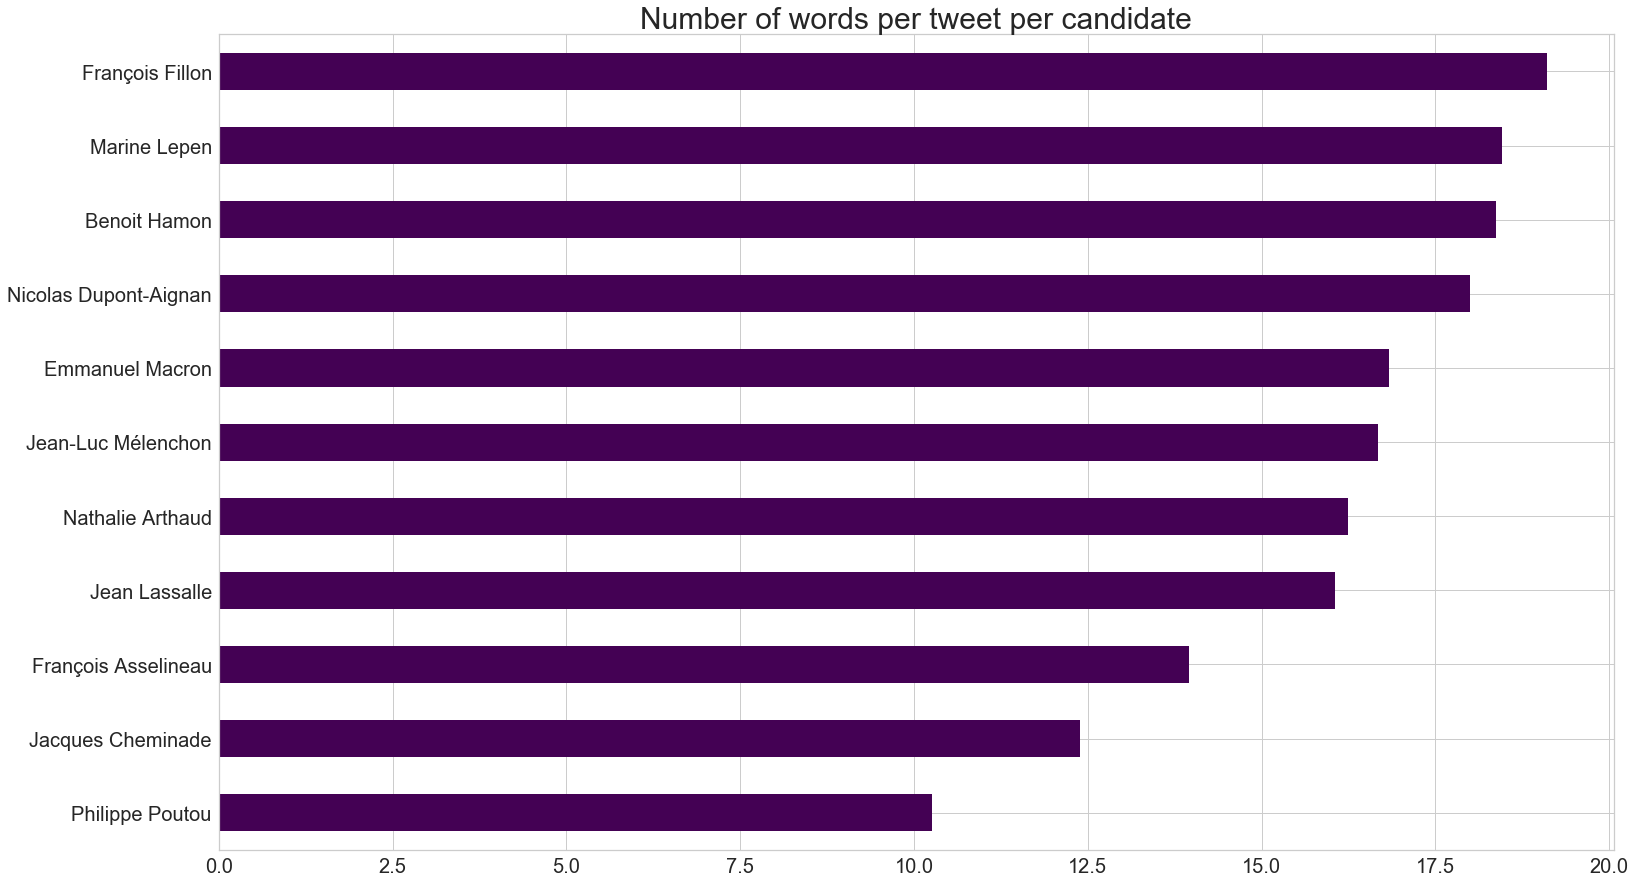

&emsp;&emsp;The average number of words per tweet depending on the candidate is indicative of an author's writing style. The difference is almost the double between François Fillon (almost 20 words per tweet) and Philippe Poutou (just over 10 words). The first develops more of his ideas in his Tweets compared with the second who has a much more concise style.

&emsp;&emsp;Here we observe the same phenomenon for the number of words per tweet: apart from Nicolas Dupont-Aignan, the five main candidates are those who communicate the most in a single tweet. This can be explained by the same phenomenon as previously described: the smaller candidates are more concise in bringing in new ideas whereas the big candidates are more on an exercise of style and filling in blanks.

&emsp;&emsp;An alternative explanation could be that the bigger candidates have a stronger communication policy and are more trained wih this exercise which allows them to be more prolific. In addition, a larger campaign team with more resources may leave them more time for this direct communication vector.

## Vocabulary diversity of candidates

By counting all the different words of each candidate, we can try to evaluate their vocabulary richness.

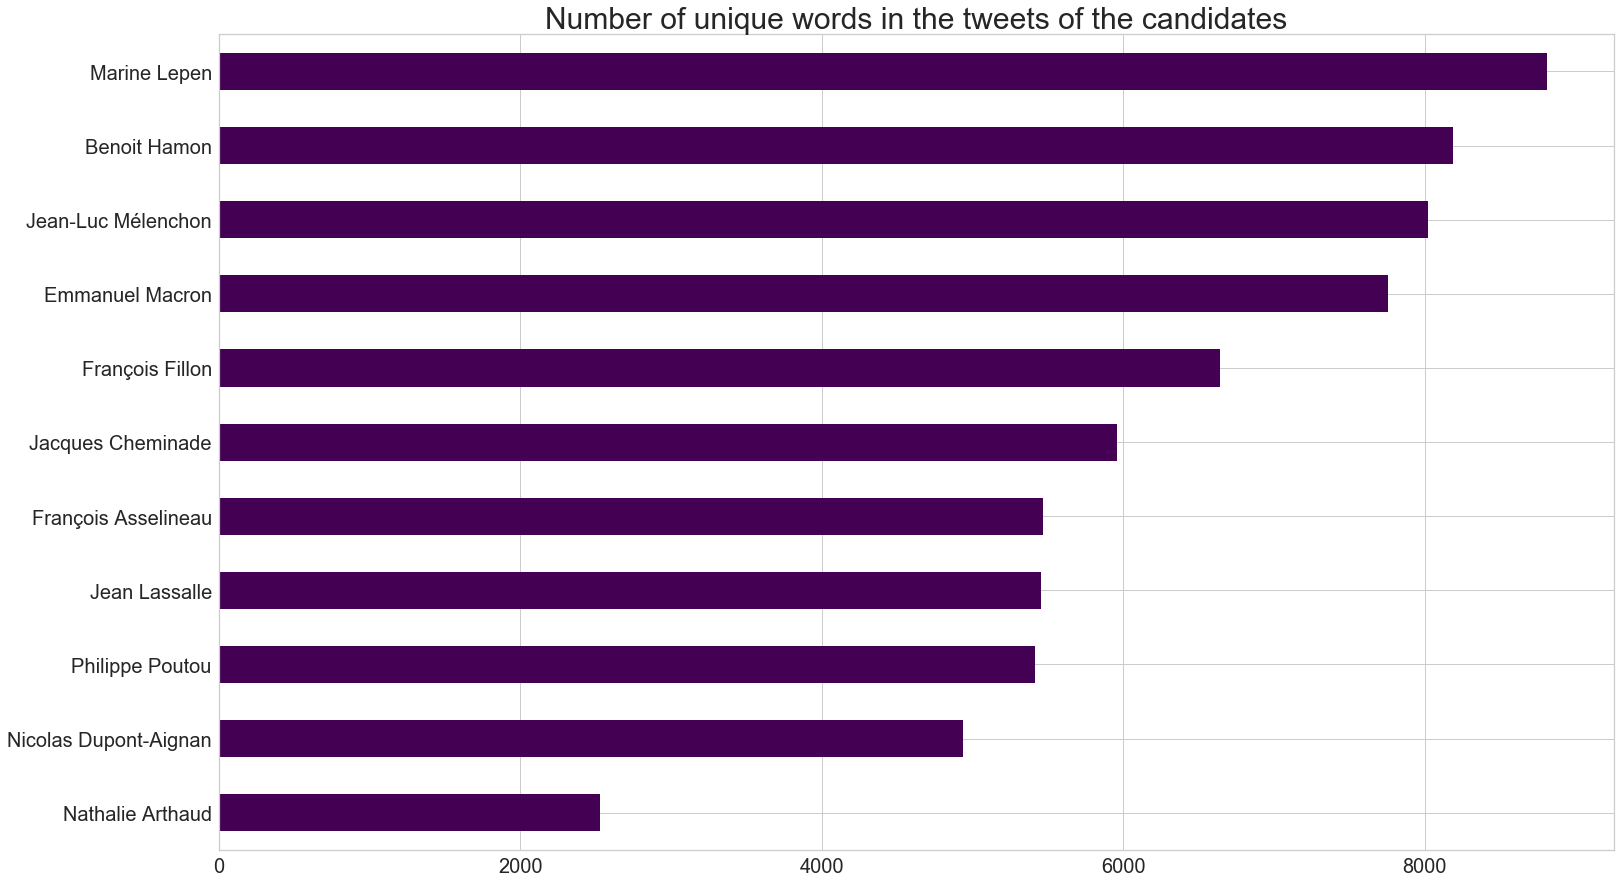

&emsp;&emsp;Let's start with an analysis of the absolute values: Marine Lepen is the candidate who used the most varied vocabulary. This is consistent with the fact that she also has the most important communication volume. But compared with Jean-Luc Mélenchon who almost equallized her on the total volume, she has a vocabulary significantly more diverse than his, contradicting his reputation as Tribun.<br>

&emsp;&emsp;It is Benoit Hamon who stands out in this comparison. He comes in second on the diversity of words used, being however behind Emmanuel Macron, and very far from Jean-Luc Mélenchon in term of number of used words. He is therefore distinguished by a greater diversity of vocabulary of the two other candidates cited.<br>

We can also easily compare Francois Asselineau, Jean Lassalle and Philippe Poutou who have the same level of vocabulary richness: when we look at the total volume of words they used, we can deduce that of the three is Philippe Poutou who has the widest vocabulary, followed by Francois Asselineau.

Let's look at the relative value ratios of this rich vocabulary to confirm this interpretation.

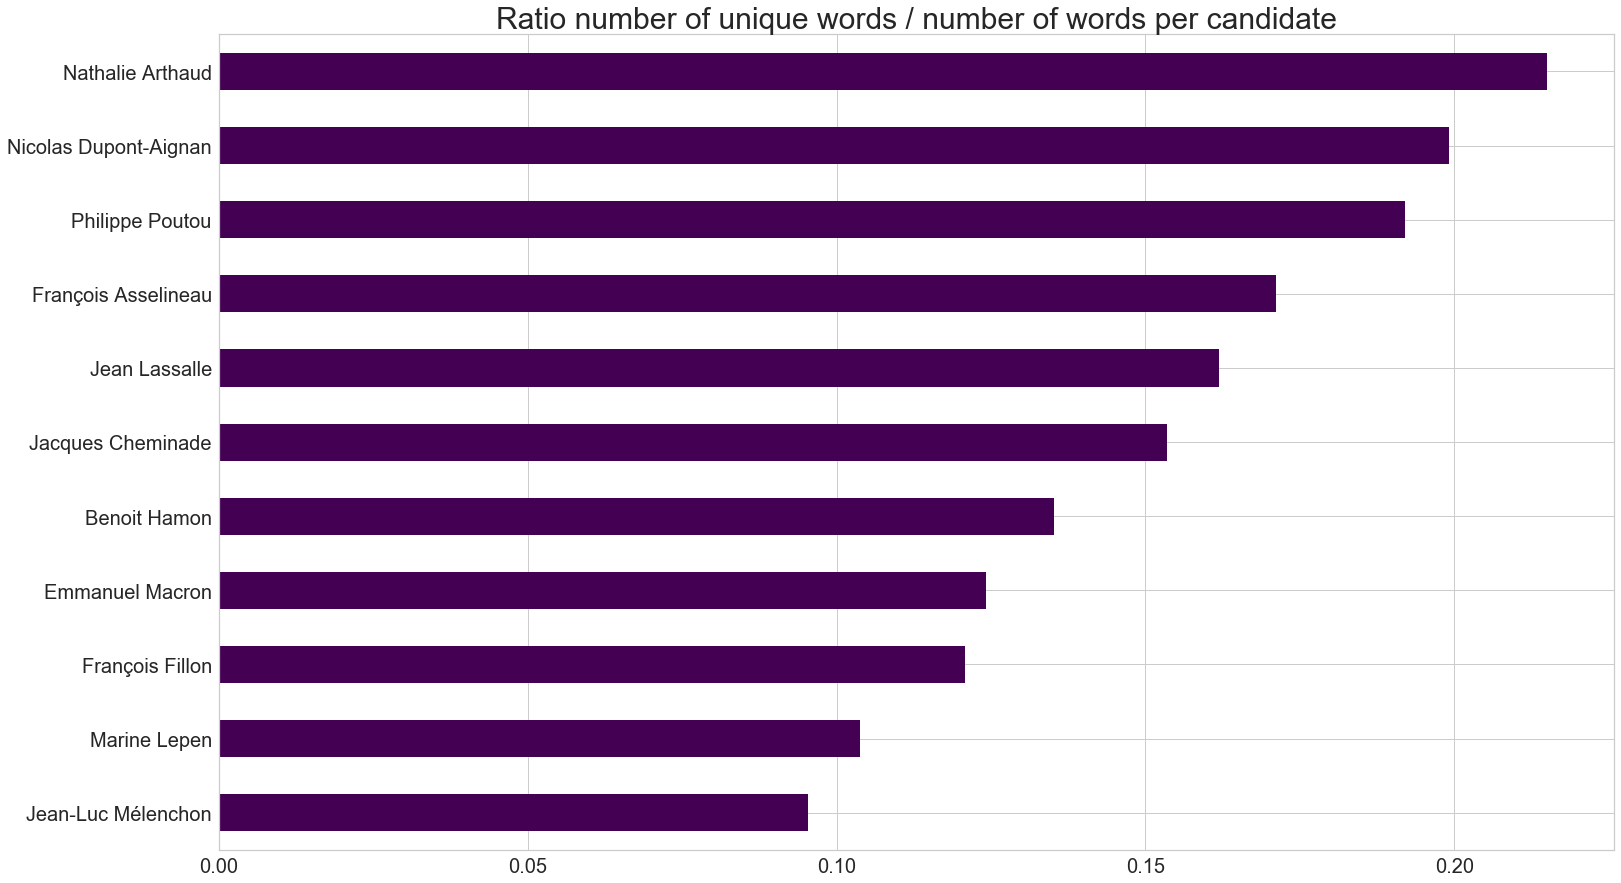

We can see that in relative terms, the diversity of vocabulary decreases with the increase in the number of words used, quite logically since the chances of repetition increase with the volume of words used. This graph makes it possible to confirm the comparisons that we have done previously.

__Summary Graph__

We will now calculate the relative value of the three indicators: the number of tweets, the number of total words and the number of unique words used, relative to the sum of its indicators of all the candidates.

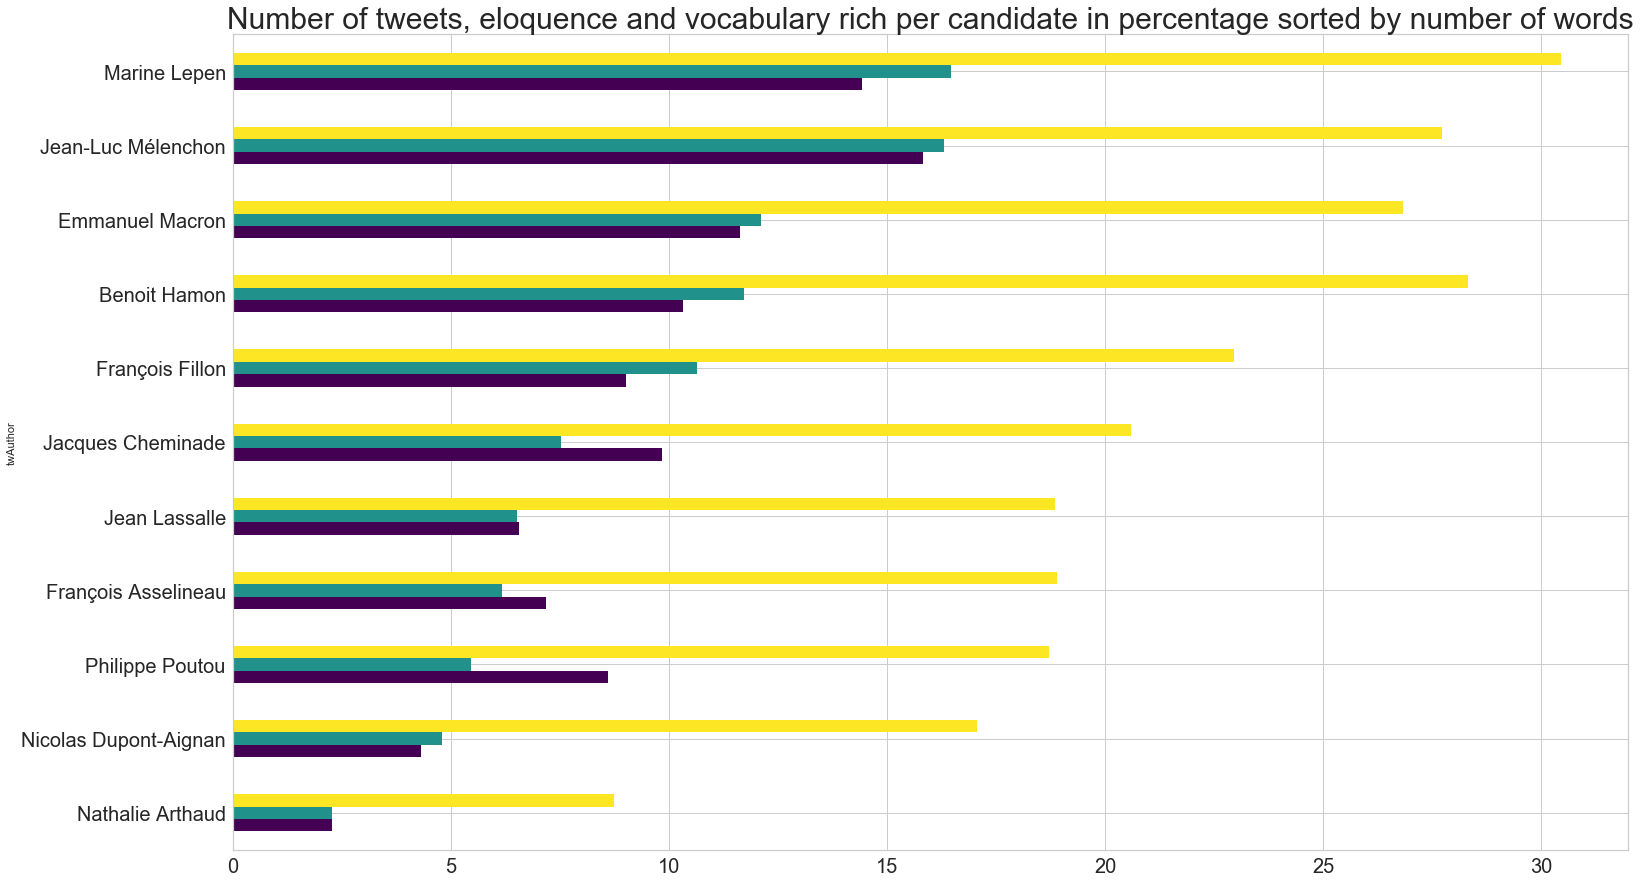

This synthetic graph allows an analysis of each candidate in relation to the totality of the candidates on the indicators *number of tweets, number of words and number of unique words*.<br>

It can be read that Marine Lepen used more than 30% of the total vocabulary used by all candidates. These tweets represent less than 15% of all tweets but more than 16% of all words used. It shows the same results as the ones analyzed previously, with for example Benoit Hamon standing out compared with the others in terms of variety of vocabulary.

## Most used words and lemmas by candidates

We will now analyze the frequencies of appearance of the words, and then of the most used tokenized lemmas by the candidates.
 
In this part, we will start pre-processing our data by removing the words that do not carry meaning, called "stopwords" to have a more easily interpretable result. We chose to include in the stopwords the names of the candidates who appeared in the thirty most used tokens, in order to study the topics discussed and not the candidates we are talking about the most.

__Word Frequency Analysis__

Let's start by analyzing the words tokenized without further transformations.

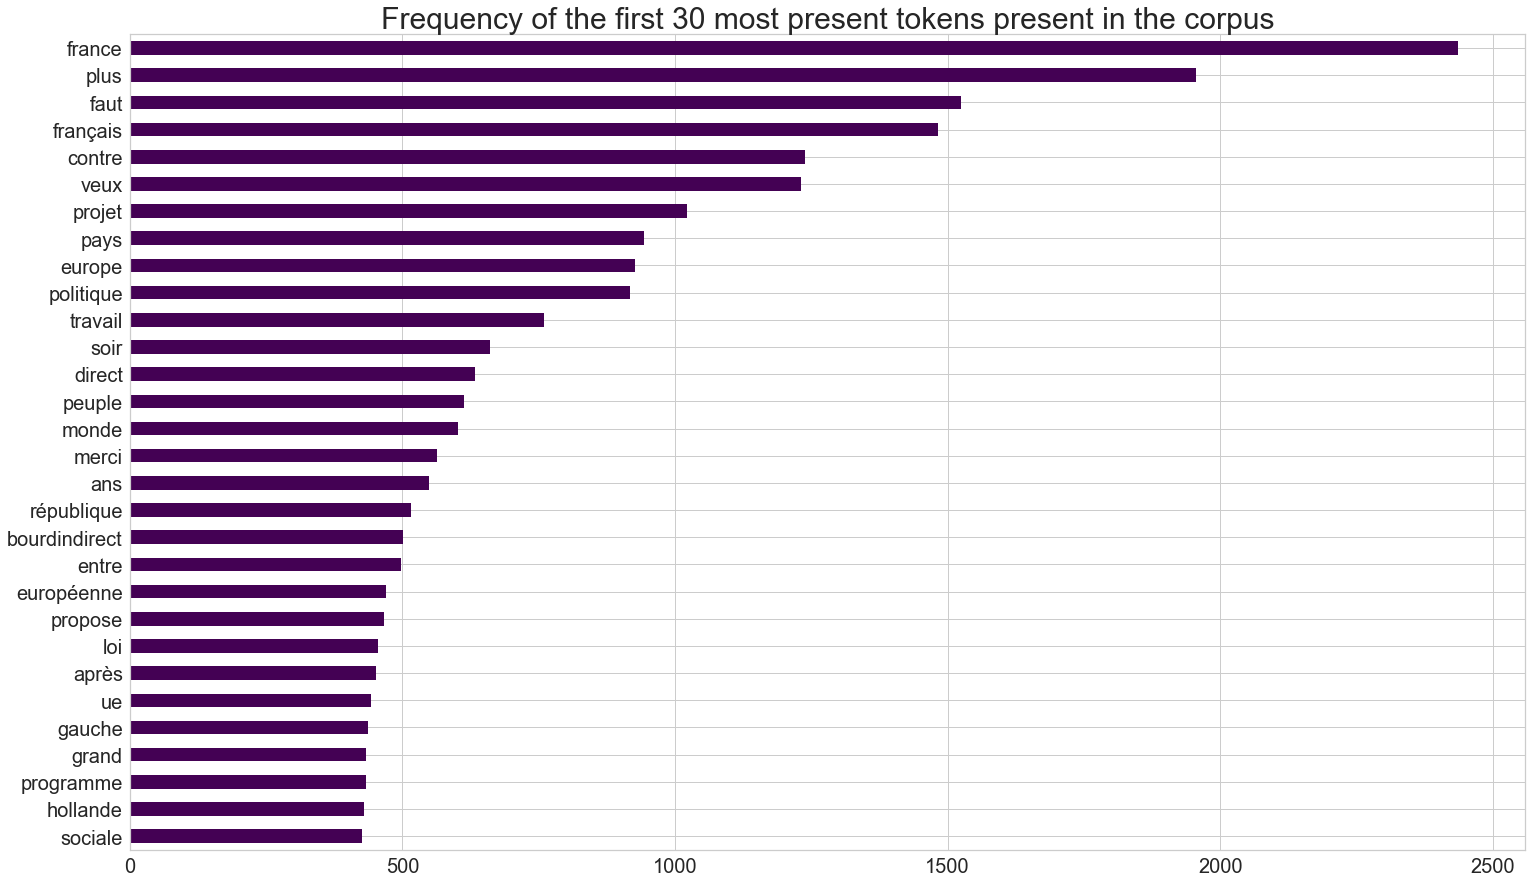

&emsp;&emsp;"France" is logically the word that stands out the most. It is interesting to see that in the first 5 words used, we find two terms of opposition "plus" and "against", "plus" still remaining ambiguous in the absence of context.<br>
In the first words representing political themes, we will extract in descending order of appearance: "France", "Europe", "work", "world", "republic", "law", "program", "social".

Since the words "france" and "europe" have synonyms in these first 30 terms ("country", "european", "eu"), we can deduce that local policies have an importance far greater than the international themes in the words of the potential presidents. "Country" is still ambiguous without context, as it could also refer to a foreign country.<br>

The notion of work is then the theme that emerges the most, showing the interest of politicians for this key theme. We will notice the social aspect that comes last in these thirty most used words, and the total absence of ecological themes.

## Frequency analysis of lemmatized tokens with a breakdown by candidate

Let's start again the same analysis but this time using lemmatized words, ie brought back to their canonized form, by bringing back the verbs to the infinitive one, the adjectives to the singular masculine ...

This transformation makes it possible to put more emphasis on words that may have several variations, such as conjugated verbs that bring their representativeness closer to reality.

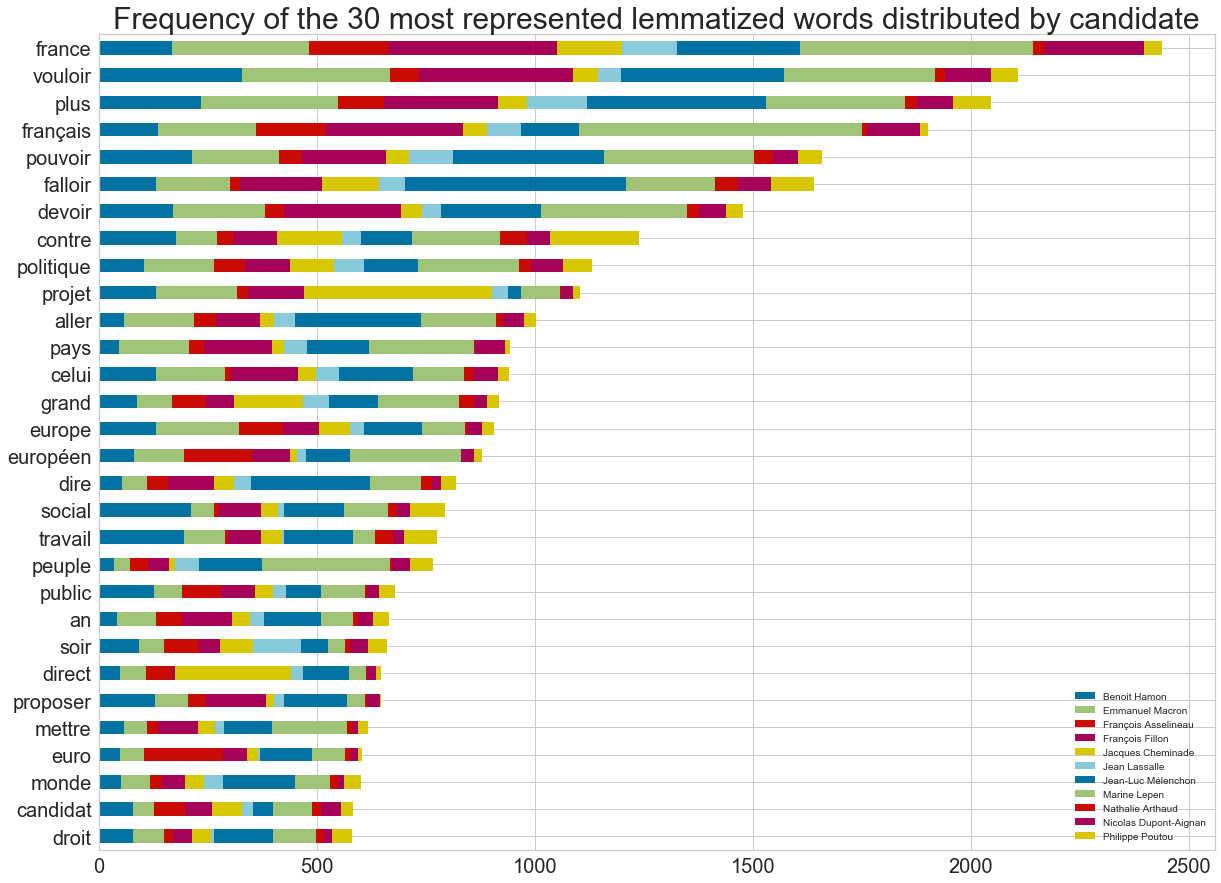

By taking the first 8 lemmas used, we find 4 verbs of action ("want", "power", "must", "must"). This shows the willingness of candidates to make their ideas more dynamic. 

The distribution of political themes has changed significantly and deserves to be re-analyzed; we see appearing in descending order of frequency: "france", "europe", "social", "work", "euro", "world", "right"

Thanks to lemmatization, we can see that the social aspect finally passes beyond the work aspect, hence the importance of this step. Candidates can now be analyzed in a more meaningful way than the others we used:

-  Benoit Hamon uses proportionally more often the terms "social" and "work", quite logically for a left wing candidate.

-  Emmanuel Macron uses the different terms in a rather homogeneous way, to note a weak part of use of the words "social" and "people".

-  François Asselineau has a relatively important use of the words "France", "French", "Europe", "European" and "Euro". His campaign credo being the French Brexit or "Frexit", this result is quite logical.

-  François Fillon had a greater use than others of the term "propose", marking a desire for change without wanting to impose his will.

-  Jacques Cheminade has talked a lot about "project" and the term "big", without coming out on concrete themes.

-  Jean-Luc Mélenchon has a stronger use of action verbs than others: "want", "go", "say", "propose", attesting to a desire to be distinguished by his dynamism. It is also he who contributes by far the most to the frequency of appearance of "world", showing more international openness compared with the other candidates.

-  Marine Lepen used more significantly the words "French", "must", "country", "people", and "put". The marked use of a patriotic vocabulary is quite logical coming from a nationalist party.

Finally, we see Nathalie Arthaud appears more significantly in her contribution to "work" and "against", as well as Philippe Poutou who also uses the term "social". These two candidates representing workers' opposition parties are evident in their themes.

## Conclusion and leads for improvement

This first analysis makes it possible to differentiate the candidates in terms of tweet writing style (number of tweets, number of words used, density of tweets, rich vocabulary, proportion of use of the different words).

The "classic" candidates representing the most important parties present a style significantly different from the "small" opposition candidates, with a higher volume of communication and density per tweet.

In terms of global themes, it is the national identification ("France", "French") as well as the verbs of actions that appear much more frequently than meaningful themes. The first concrete theme, namely "social" appears in 18th position.

We could improve this study by supplementing it with a grammar analysis by candidate, by identification of named entities to distinguish the proper nouns and analyze their frequency of occurrence, and by analyzes using bi grams or trigrams. to contextualize more words.

# Thematic search by a clustering method

The purpose of this section is to identify the main topics addressed by all candidates, and then compare the different topics between candidates. Since the data are not labeled, we must use an unsupervised method.

To choose the most appropriate algorithm, we uses the scikit-learn cheat-sheet decision tree: we want to predict a category with unlabeled data out of a total population of more than 10,000. This brings us to a choice between the MINIBatch algorithm and the Kmeans. We choose the latter because we have a better understanding of it.

To determine the number of clusters to use, we will start using a variance calculation between the clusters depending on the number chosen.

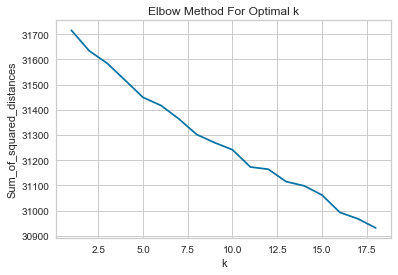

[0.00212544 0.00278767 0.00335282 0.00407884 0.00469033 0.00482788
 0.00570919 0.00579129 0.00650798 0.00633804 0.00647983 0.00737341
 0.00700676 0.00763122 0.00801483 0.00759969 0.00826832 0.00828573
 0.00881771]


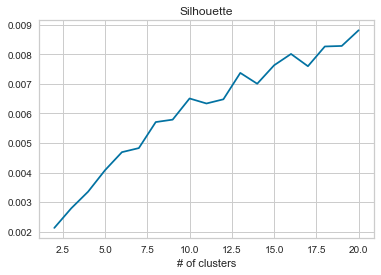

The variance curve has a straight curvature, with breaks on even numbers for which the algorithm is less efficient. In absence of a significant rupture in the curve, we will therefore try to determine empirically the optimal number of clusters by testing different values for k, where k is the number of clusters.

Once the clustering done, we will display the most frequent words of the cluster thus illustrating it the best, in order to help us to clear a theme of this group of words.

To search for specific themes rather than general themes, we will use the tfidf rather than the frequency in vectorization method of bagwords.


## Study on the whole body of tweets, with empirical determination of the number of optimal clusters

### Result of a kmeans algorithm with 9 clusters

We will start 9 clusters and then gradually go down and compare the different results to see the value which best identify the themes. We do not start higher because a higher value would be tedious to exploit for later comparisons between different candidates.

Top terms per cluster:
Cluster 0:
 premier
 liberté
 tour
 ministre
 égalité
 français
 fraternité
 france
 peuple
 mai
Cluster 1:
 pays
 france
 plus
 français
 politique
 avenir
 grand
 europe
 million
 européen
Cluster 2:
 contre
 europe
 merci
 lutter
 lutte
 plus
 soutien
 européen
 terrorisme
 projet
Cluster 3:
 celui
 celle
 france
 plus
 français
 europe
 contre
 projet
 vie
 politique
Cluster 4:
 france
 français
 plus
 insoumis
 battre
 projet
 grand
 vivre
 république
 vive
Cluster 5:
 bourdindirect
 rmc
 bfmtv
 français
 plus
 droit
 rmcinfo
 impôt
 jjbourdinrmc
 social
Cluster 6:
 monde
 france
 plus
 europe
 entier
 pays
 grand
 beaucoup
 travail
 changer
Cluster 7:
 français
 plus
 politique
 projet
 social
 européen
 travail
 public
 peuple
 mettre
Cluster 8:
 direct
 facebook
 youtube
 suivre
 meeting
 internet
 photo
 publier
 question
 inscrivez


Here are the different themes that we thinkcan deduced based on the most representative words of each cluster

- Cluster 0: patriotism / elections

- Cluster 1: the future of France and Europe

- Cluster 2: fighting terrorism with the help of Europe

- Cluster 3: France's opposition to Europe

- Cluster 4: fight and insubordination to protect the republic

- Cluster 5: reference to media associated with law and social

- Cluster 6: France and the world

- Cluster 7: left-wing themes: social policy and work, public

- Cluster 8: communication, especially in the IT field

We see that three clusters revolve around Europe with slight variations, and since we try to synthesize the information as much as possible, the number of clusters seems to be too important here.

### Result of a kmeans algorithm with 7 clusters

Top terms per cluster:
Cluster 0:
 français
 contre
 politique
 direct
 pays
 travail
 celui
 grand
 europe
 social
Cluster 1:
 prendre
 permettre
 démocratie
 vote
 intérêt
 français
 défendre
 utile
 peuple
 celui
Cluster 2:
 projet
 européen
 section
 heure
 union
 français
 europe
 parlement
 agriculture
 commission
Cluster 3:
 france
 français
 insoumis
 pays
 celui
 europe
 battre
 vivre
 grand
 monde
Cluster 4:
 frontière
 salarié
 agriculteur
 immigration
 arrêter
 déloyal
 concurrence
 national
 droit
 contre
Cluster 5:
 penser
 ami
 solidarité
 cher
 peuple
 victime
 famille
 français
 retrouver
 invite
Cluster 6:
 plus
 france
 français
 grand
 pays
 europe
 jamais
 politique
 celui
 an


Here are the different themes that we think can be deduced based on the most representative words of each cluster

- Cluster 0: work and social themes in France and Europe

- Cluster 1: usefulness of the vote for democracy

- Cluster 2: Europe and agriculture

- Cluster 3: the French fight for a big country against Europe and the world

- Cluster 4: protectionist policy (border protection, unfair competition, stop immigration)

- Cluster 5: the French are in solidarity with the families of the victims

- Cluster 6: France and Europe

We see that here France and Europe still comes back three times in different clusters, the number of clusters still seems too important.

### Result of a kmeans algorithm with 5 clusters

Top terms per cluster:
Cluster 0:
 français
 contre
 politique
 direct
 pays
 travail
 celui
 grand
 europe
 social
Cluster 1:
 prendre
 permettre
 démocratie
 vote
 intérêt
 français
 défendre
 utile
 peuple
 celui
Cluster 2:
 projet
 européen
 section
 heure
 union
 français
 europe
 parlement
 agriculture
 commission
Cluster 3:
 france
 français
 insoumis
 pays
 celui
 europe
 battre
 vivre
 grand
 monde
Cluster 4:
 frontière
 salarié
 agriculteur
 immigration
 arrêter
 déloyal
 concurrence
 national
 droit
 contre
Cluster 5:
 penser
 ami
 solidarité
 cher
 peuple
 victime
 famille
 français
 retrouver
 invite
Cluster 6:
 plus
 france
 français
 grand
 pays
 europe
 jamais
 politique
 celui
 an


Analysis of the themes of the 5 clusters:

- Cluster 0: the French fight for a big country against Europe and the world

- Cluster 1: social work policy

- Cluster 2: Europe and the fight against terrorism

- Cluster 3: democratic revolution against government policy

- Cluster 4: agriculture

From 7 to 5 clusters the themes remain relatively identical, less detailed with 5 clusters but allowing to summarize more information. We will therefore keep this metric for the rest of the study in order to have a common scale of comparison between the candidates

## Comparison of the different candidates with each other and with the general themes addressed

Let's start by selecting candidates with a vocabulary significantly different from other candidates based on Part 2 of this study.

We choose to study the themes of Marine Lepen and Jean-Luc Mélenchon for the main candidates, who are ideologically opposed and with a distribution of word use quite different from the other candidates.

We will compare these two candidates with Jacques Cheminade who is a small candidate who also stands out from the others by his vocabulary.

### Jean Luc Mélenchon

Top terms per cluster:
Cluster 0:
 france
 18mars2017
 laforcedupeuple
 onpc
 celui
 monde
 monsieur
 proposer
 europe
 peuple
Cluster 1:
 rmc
 bourdindirect
 bfmtv
 impôt
 plus
 guerre
 france
 rendez
 ps
 travailleur
Cluster 2:
 programme
 commun
 avenir
 chiffrage
 émission
 france
 insoumis
 diffusion
 spécial
 lire
Cluster 3:
 gens
 franceinter
 questionspol
 plus
 le79inter
 voter
 beaucoup
 politique
 travailler
 vie
Cluster 4:
 plus
 youtube
 merci
 vue
 facebook
 grand
 million
 bravo
 20
 loin


Here are the five themes we can identify from Jean-Luc Mélenchon's tweets:

- Cluster 0: The people of France against Europe and the world

- Cluster 1: program themes: war / taxes / workers / media

- Cluster 2: Dissemination of the program for a common future

- Cluster 3: Radio France inter, people, work

- Cluster 4: Internet communication

We can see that the main themes of the author's campaign stand out in cluster 1. Three of the clusters revolve around communication, with the diffusion of its program, the types of Internet communication and the radio France Inter.

Only one theme emerges identical to the general themes: France, Europe and the world.

The candidate thus differs distinctly from general themes, with a recurrence of themes revolving around communication.

### Marine Le Pen

Top terms per cluster:
Cluster 0:
 france
 pays
 peuple
 politique
 grand
 mlp
 plenpe
 européen
 1ermaifn
 meetingpari
Cluster 1:
 contre
 national
 frontière
 lutter
 lutte
 front
 terrorisme
 retrouver
 fondamentalisme
 islamiste
Cluster 2:
 plus
 menl
 europe
 européen
 peuple
 france
 union
 ue
 pays
 rien
Cluster 3:
 français
 peuple
 france
 protéger
 défendre
 européen
 rendre
 politique
 legranddébat
 intérêt
Cluster 4:
 mettre
 économique
 patriotisme
 place
 concurrence
 déloyal
 œuvre
 fin
 entreprise
 protectionnisme


Here are the five themes we can identify tweets from Marine Lepen:

- Cluster 0: The people of France in front of Europe, the European Parliament, meeting of Marine Lepen

- Cluster 1: restoring borders to fight terrorism from Islamic fundamentalism

- Cluster 2: France is nothing against the European Union

- Cluster 3: policy to protect the interest of the French against Europe

- Cluster 4: implementation of a protectionist policy to protect companies from unfair competition

Three of the five clusters revolve around France's opposition to the European Union, presenting this theme as very important in the candidate's strategy and program.

It is therefore closer to the Global Themes addressed by all candidates, where Europe occupies a preponderant place.

### Jacques Cheminade

Top terms per cluster:
Cluster 0:
 direct
 contre
 financier
 daln
 france
 jc
 loi
 hollande
 presidentielle2017
 live
Cluster 1:
 cheminade2017
 plan
 guyane
 voici
 présidentielle2017
 crisesocial
 via
 presidentielle2017
 action
 cayenn
Cluster 2:
 projet
 section
 heure
 agriculture
 brest
 fnsea
 découvrir
 discours
 30
 jeudi
Cluster 3:
 facebook
 internet
 youtube
 meeting
 grand
 inscrivez
 prochain
 direct
 19h30
 18
Cluster 4:
 dialogue
 nation
 question
 poser
 soir
 daln
 prochain
 direct
 15
 min


Here are the five themes we can identify tweets of Jacques Cheminade:

- Cluster 0: finance opposition law

- Cluster 1: action plan against the social crisis in French Guiana

- Cluster 2: project for agriculture

- Cluster 3: internet communication

- Cluster 4: dialogue and questions to ask in the next direct debate

The first three clusters distinguish it from the general theme and the two previous candidates.

## Conclusion and ways of improvement

&emsp;&emsp;The kmeans algorithm is quite efficient for grouping distinctive themes thanks to the tfidf vectorization. The groups of words that stand out allow us to identify coherent themes that represent each candidate in his or her speech. A use of bigrams or trigrams could have improved the associations between the emerging words, some of which may be ambiguous, but would have greatly increased the processing times.

We see that the numbers interfere with the clustering, we could delete them in pre-treatment, as well as hashtags such as "présidentielle2017" to improve the interpretation.

# Predicting an author based on a tweet

## Loading and Preprocessing the data

One of the goals of this project was to identify an author based on a tweet. 

&emsp;&emsp;For this goal, we will start using the data we obtained at the end of *Part 2 - 3) Lemmatizing sentences*. That is, we will use the raw sentences after they were lemmatized, but before they were cleaned. Indeed, we will need to use the lemmatized words in this part in order to create a matrix of the words used in each tweet. If this part was skept and we used the raw tweets instead, our matrix would be uselessly complex (by repeating a word with different conjugated forms for instance).

Therefore, such a complex matrix would cause two issues :

-  The weight of similar words would be lower, and therefore we would see an increase in the rate of falsely recognized words (that is, the precision of our model would be lower)

-  Our model would overfit the data and have a very high recall.

Thus, we will first import the lemmatized sentences.

In [2]:
with open("data/data_v0_2_lemma_on_text.json") as json_file:
    data = json.load(json_file)

Then, we need to import these data in a pandas DataFrame and preprocess the text the same way we did earlier (removing URLs, stopwords...).

We decided to add specific features to our model. That is, we relied on Castro & Lindauer (2012) in order to see what further metrics could be of interest in our model. Therefore, we decided to count the number of times a candidate refered to her/himself or refered to other people, or mentioned the concept of "we".

Below we summarized two metrics based on the available data : 

-  Main words used during the campaign

-  Number of tweets per candidate

&emsp;&emsp;The second metrics is among the most important one here. Before we split the dataset into a training and test set, we should check for the balance of the dataset among classes. Although imbalance may not cause too many problems in our Machine Learning algorithm performance, it is still something we should take into consideration when interpreting the results of our algorithm. Indeed, the main metrics affected by class imbalance is the model's accuracy. However, precision, recall and F1 are scores we can use with imbalanced datasets.

Should our data be highly imbalanced, we will consider different ways to deal with this issue.

Vocabulary length of all the words used in tweets: 22503

50 words most commonly used on Twitter during the campaign:
pas, france, vouloir, plus, français, pouvoir, falloir, devoir, contre, politique, projet, aller, pays, celui, grand, européen, dire, europe, social, peuple, travail, aujourdhui, public, soir, proposer, mettre, direct, monde, droit, candidat, premier, merci, an, entrer, national, euro, question, loi, monsieur, république, président, programme, après, emploi, heure, gauche, vie, voir, élection, entreprise


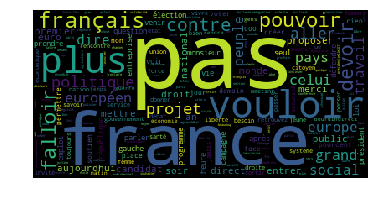

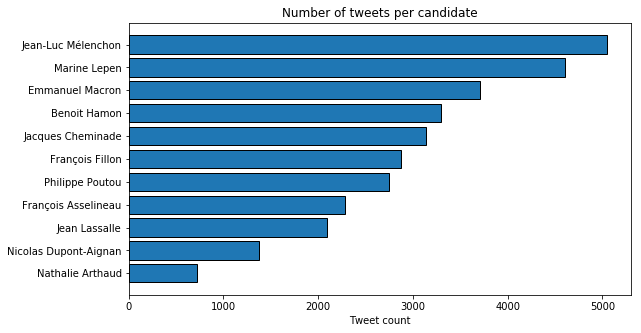

As one could expect in most cases, our 11 classes are imbalanced. This is quite an issue as our ML algorithm may have a higher accuracy for the classes "Jean-Luc Mélenchon" and "Marine Lepen" than for the classes "Nicolas Dupont-Aignan" and "Nathalie Arthaud".

Several techniques can be used to overcome this problem, such as collecting more data, undersampling, oversampling or testing different algorithms. <br>

-  __Collecting more data__ : Since the data contain all the tweets written by the candidates during the presidential elections, we know we will not be able to collect any more data. 

-  __Oversampling__ : The main algorithm known for oversampling is the SMOTE algorithm (Chawla, Bowyer, Hall & Kegelmeyer, 2002). However, while it applies well on low dimensional features, oversampling may overweight significantly cases with lower amount of tweets. Therefore, we will potentially run it later to see if it increases our model performance, but we will not focus on it for now.

-  __Undersampling__ : We might also consider trying undersampling afterwards, although we would like to keep the training data as representative of the dataset as can be.

-  __Try different algorithms__ : For a first approach, we will try to give priority to this method

## How will our Machine Learning Algorithms work ?

We can take some time here to investigate the data we have and what are the next steps required to run Machine Learning algorithms on these data.

&emsp;&emsp;We will use 2 columns among all the ones specified above. Namely, we will use the "*text*" column as our feature variables, and the "*twAuthor*" column as our classifier label. Therefore, our first task will be to select these specific columns.<br>

&emsp;&emsp;After doing so, our second task will be to separate our dataset in a training set and a test set. This step allows us to train our model on training data, and then see how well it fits on test data. This step is extremely important as it may lead to a model __overfit__ (*that is, our model fits the training data too much, and therefore can only represent and be predictive of those training data*), or __underfit__ (*in which case our model misses the trend of training data*). This training/test set separation is usually done with a proportion ranging from 80%/20% to 70%/30%, depending on the amount of hyperparameters in our model. We will go with an 80%/20% separation and consider later on to decrease the amount of observations in our training set. <br>

&emsp;&emsp;Finally, we need to create a pipeline which will process our data. This pipeline is a way to apply the different transformation required in machine learning in a single process. Our pipeline consists of the following architecture :

-  __Vectorizer__ : The vectorizer is used to convert the sentences in the "*twText*" column into a matrix, where each column is a unique word present in the entire corpus, and each row the count of words for each sentence. We will use two different vectorizers to compare their performance : <br> *The CountVectorizer, which gives the total count of apparition of each word in each sentence, and the TfidfVectorizer, which returns a tf-idf matrix.*

-  __Features selection__ : The Chi kernel will allow us to select the k best features in our training set and use these. Therefore, we do not use words which are not representative of the corpus. Here, we will select the first 10000 features in order to have a discriminative capacity without loosing too much specificity.

- __Classifier__ : The classifier corresponds to our model. We can insert here any necessary algorithm and tune the hyperparameters as needed.

## Testing our first algorithm

&emsp;&emsp;First of all, we will try our pipeline with the LinearSVC classifier, as Support Vector Machines seem to be the most suited algorithms for multiclass classification tasks (*source : http://dlib.net/ml_guide.svg*). Support Vector Machines (SVMs) look for hyperplanes that best separate classes. Although we will try out other algorithms later on, here is a reminder of the pros and cons of Support Vector Machines, which will be important to have in mind when interpreting the model:

__*Pros:*__ Most of all, SVMs easily handle imbalanced datasets by reweighting each point (Akbani, Kwek & Japkowicz, 2004), this is done by adjusting the slack penalty (C). This makes it an important asset for our algorithm as we saw earlier that observations were imbalanced among classes. Furthermore, minimization of the $l^1$ norm in SVM is done by default, but as it can be unstable and more unefficient when handling a large dataset like ours than using the $l^2$ norm and making it a quadratic programming problem. 

__*Cons:*__ Overall, SVMs are not the most computationally efficient algorithms, quite in particular when handling large datasets. Finally, weights can be more difficult to interpret compared with other algorithms, as coefficients represent hyperplanes weights.

__Interpreting our model: Notions and concepts__

Once we run our model, the algorithm will try to correctly classify as many observation as possible based on the features provided in our X_train dataset. Once the model is built, it is ran again on a smaller test dataset, and different metrics allow us to determine its quality:
-  __Precision__: Precision tells you of all the positively classified observations, how many were correctly classified as positive. It is calculated using the following formula: $Pre = \frac{True Positives}{True Positives + False Positives}$

-  __Recall__: Recall is usefull to assess the number of relevant observations our algorithm returned. To put it simply, of all the originally positive data, how much did our algorithm return? Its formula is: $Rec = \frac{True Positives}{True Positives + False Negatives}$

- __F1-Score__: The F1 Score can be considered as a balance between precision and recall. It is a weighted harmonic mean where the best score is 1.0 and the worst is 0.0: $F1 = 2\times\frac{Precision \times Recall}{Precision + Recall}$

In [55]:
Xtest = df["text"]
ytest = df["twAuthor"]


X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.20,random_state=123)

pipeline = Pipeline([("vect", CountVectorizer()),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC())])
model = pipeline.fit(X_train, y_train)
model_svc_original = model.score(X_test, y_test)
print("Accuracy of the original model:", model_svc_original)

prediction = model.predict(X_test)

clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

Accuracy of the original model: 0.7029144468818552


,f1-score,precision,recall,support
Benoit Hamon,0.599856,0.595989,0.603774,689.0
Emmanuel Macron,0.636796,0.629530,0.644231,728.0
François Asselineau,0.750542,0.779279,0.723849,478.0
François Fillon,0.642496,0.637124,0.647959,588.0
Jacques Cheminade,0.784441,0.801325,0.768254,630.0
Jean Lassalle,0.625995,0.674286,0.584158,404.0
Jean-Luc Mélenchon,0.802638,0.800607,0.804680,983.0
Marine Lepen,0.815442,0.794027,0.838043,920.0
Nathalie Arthaud,0.546939,0.592920,0.507576,132.0
Nicolas Dupont-Aignan,0.467909,0.576531,0.393728,287.0


&emsp;&emsp;We will start interpreting by taking a look at the last three lines of the report. We can see 3 different ways to interpret our model's metrics by using either the micro average, macro average and weighted average. Understanding the differences between averages is quite important as we can see that these values can be quite heterogeneous.<br>

Micro average represents the performance of our model when classes are imbalanced and we want a model which performs best on the largest classes, whereas macro average represents the same thing only this time to perform best on minority classes. Finally, the weighted average is used when classes are balanced or our model took into consideration class imbalance, which is the case with LinearSVC.<br>

&emsp;&emsp;We can conclude that our first model is already quite good at predicting classes, although there is still room for improvement. Recall and precision are both equal to 0.70. This allows us to conclude our model is fairly robust both in avoiding falsely classified positive observations 70% of the time and in correctly recalling 70% of all positive observations.

&emsp;&emsp;Then we can take a look at each class separately in order to check the performance of our algorithm on the different authors. Ideally, our algorithm would have consistant metrics across all classes, meaning that it may perform in equal ways for each candidate. However, as we can see above, scores are heterogeneous across classes, with the lowest scores achieved for Nicolas Dupont-Aignan and Nathalie Arthaud. This can be easily explained as they are the two candidates who tweeted the least. As such, our model will not be able to correctly classify our cases better than chance for these two persons. <br>

The best scores on the opposite were achieved by the two highest tweeters, namely Jean-Luc Mélenchon and Marine Lepen, with about 80% of accuracy and recall for each.

## Improving our model

### Specify the vectorizer's parameters

Next, we will try out various ways to improve our model, and see if we can manage to improve its performance to at least 75%. The first thing we can do is improve our vectorizer. We did not specify any parameters for the "vec" part of the pipeline. Here, we will see how well we improve the model's accuracy by setting some parameters to our vectorizer.<br>

&emsp;&emsp;The analyzer is set to word in order to tell the vectorizer to look at words only, not at ngrams. The preprocessor will be set to none in order to prevent any string processing, and we will only select the first 10000 most relevant features ordered by frequency.

In [56]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, max_features=10000)

X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.2,random_state=123)

pipeline = Pipeline([("vect", vectorizer),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC())])

model = pipeline.fit(X_train, y_train)
model_svc_vect = model.score(X_test, y_test)
print("Accuracy of the vectorizer model:", model_svc_vect)

Accuracy of the vectorizer model: 0.7040112817298653


This change did not significantly improve our model, as its accuracy is still of .70%. This can be due to several reasons which we will investigate step by step. 

### Dealing with class imbalance

&emsp;&emsp;As we saw earlier, the main problem we will encounter here is the imbalance between the different classes. Even though we saw that the Linear SVC algorithm dealt well with class imbalance, we will look at two different ways to deal with this problem and see how much it affects our model. Even if this method does not reveal useful with the Linear SVC algorithm, we will investigate later on its impact on other algorithms.

As said, we will look at two ways to deal with our imbalance:

-  Synthetic Minority Over-sampling Technique (SMOTE): Designed by Chawla, Bowyer, Hall and Kegelmeyer (2002), the SMOTE technique aims at over-sampling each class to match the largest one.

-  NearMiss: Designed by Mani and Zhang (2003), the NearMiss method can be thought of as the opposite of the SMOTE method. Here, each class will be undersample to match the smallest one.

The effects of each technique are shown in the cell below. Please take the time to consider what happens in each case.

"Normal data distribution: Counter({'Jean-Luc Mélenchon': 5048, 'Marine Lepen': 4605, 'Emmanuel Macron': 3711, 'Benoit Hamon': 3297, 'Jacques Cheminade': 3136, 'François Fillon': 2878, 'Philippe Poutou': 2748, 'François Asselineau': 2288, 'Jean Lassalle': 2096, 'Nicolas Dupont-Aignan': 1378, 'Nathalie Arthaud': 725})"

"SMOTE data distribution: Counter({'Nathalie Arthaud': 5048, 'Jacques Cheminade': 5048, 'Jean-Luc Mélenchon': 5048, 'François Asselineau': 5048, 'Benoit Hamon': 5048, 'Marine Lepen': 5048, 'Emmanuel Macron': 5048, 'Nicolas Dupont-Aignan': 5048, 'Jean Lassalle': 5048, 'Philippe Poutou': 5048, 'François Fillon': 5048})"

"NearMiss data distribution: Counter({'Benoit Hamon': 725, 'Emmanuel Macron': 725, 'François Asselineau': 725, 'François Fillon': 725, 'Jacques Cheminade': 725, 'Jean Lassalle': 725, 'Jean-Luc Mélenchon': 725, 'Marine Lepen': 725, 'Nathalie Arthaud': 725, 'Nicolas Dupont-Aignan': 725, 'Philippe Poutou': 725})"

__Test of the SMOTE algorithm applied to our data:__

In [43]:
classifier = LinearSVC

smote_pipeline = make_pipeline_imb(SMOTE(random_state = 123), 
                                   classifier(random_state = 123))

x_train_imb = vectorizer.transform(X_train)
x_test_imb = vectorizer.transform(X_test)
smote_model = smote_pipeline.fit(x_train_imb, y_train)
smote_prediction = smote_model.predict(x_test_imb)

model_svc_smote = smote_model.score(x_test_imb, y_test)
print("Accuracy of the smote model:", model_svc_smote)

Accuracy of the smote model: 0.6827013475399561


__Test of the NearMiss algorithm applied to our data:__

In [44]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, max_features=10000)

nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state = 123), 
                                      classifier(random_state = 123))

x_train_imb = vectorizer.fit_transform(X_train)
x_test_imb = vectorizer.transform(X_test)

nearmiss_model = nearmiss_pipeline.fit(x_train_imb, y_train)
nearmiss_prediction = nearmiss_model.predict(x_test_imb)

model_svc_nearmiss = nearmiss_model.score(x_test_imb, y_test)
print("Accuracy of the nearmiss model:", model_svc_nearmiss)

Accuracy of the nearmiss model: 0.5261673456596678


&emsp;&emsp;Interestingly enough, using both the SMOTE and the NearMiss algorithms before running the Linear SVC did not improve our models. Quite the opposite, the accuracy decreased with the SMOTE method, and completely dropped to 52% with the NearMiss method. This confirms the fact that Support Vector Machines are algorithms which perform well on imbalanced classes.

### Using a different vectorizer

&emsp;&emsp;So far we mostly used the CountVectorizer as our pipeline's vectorizer. Here, we will use the TfIdfVectorizer, in order to have normalized relative frequencies for each term. We will directly implement some parameters in our vectorizer: The n_gram range tells our vectorizer to analyze words only instead of pairs of words (as tweets have a short length, pairs of words might be less meaningful than whole words). Then, we specify the stopwords and that we will use a sublinear function, which will decrease the importance of words which are used too often.

In [57]:
tf_vectorizer = TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)

pipeline = Pipeline([("vect", tf_vectorizer),
                     ("chi", SelectKBest(chi2, k = 10000)),
                     ("clf", LinearSVC())])

model = pipeline.fit(X_train, y_train)
model_svc_tfidf = model.score(X_test, y_test)
print("Accuracy of the tfidf model:", model_svc_tfidf)

Accuracy of the tfidf model: 0.7229708555311815


Using the Tf-Idf as our vectorizer, we improved our model from 70% accuracy to 72.3% accuracy, which brings us closer to our expected 75% accuracy. Finally, we can try to improve our model by specifying our algorithm's hyperparameters.

### Specifying hyperparameters

So far, our algorithm was run without any tuning of its parameters, which we will use here:

-  __C__: The penalty parameter of the error term. In other words, it defines the "width" of the border drawn by the algorithm. The larger the C-Value, the smaller the border.

- __penalty__: The norm used in the penalization. $l^1$ is a linear normalization, $l^2$ a quadratic normalization.

- __max_iter__: The maximum number of iteration to be run

- __dual__: This should be set to False when the number of observations is superior to the number of features.

In [58]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC(C = 0.5, penalty = "l2", max_iter = 500, dual = False, random_state = 123))])
model = pipeline.fit(X_train, y_train)

model_svc_tfidf = model.score(X_test, y_test)
print("Accuracy of the hyperset model:", model_svc_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the hyperset model: 0.7232842369163272
                       precision    recall  f1-score   support

         Benoit Hamon       0.62      0.63      0.62       689
      Emmanuel Macron       0.65      0.69      0.67       728
  François Asselineau       0.77      0.75      0.76       478
      François Fillon       0.68      0.66      0.67       588
    Jacques Cheminade       0.85      0.79      0.82       630
        Jean Lassalle       0.65      0.62      0.64       404
   Jean-Luc Mélenchon       0.79      0.85      0.82       983
         Marine Lepen       0.78      0.87      0.82       920
     Nathalie Arthaud       0.67      0.48      0.56       132
Nicolas Dupont-Aignan       0.64      0.41      0.50       287
      Philippe Poutou       0.68      0.67      0.68       543

            micro avg       0.72      0.72      0.72      6382
            macro avg       0.71      0.68      0.69      6382
         weighted avg       0.72      0.72      0.72      6382



Again, we slightly improved our model's accuracy (by 0.5%). Interestingly, we can see that the values for our candidates are now more stable and more centered towards the mean metrics, except for Nathalie Arthaud and Nicolas Dupont-Aignan, probably due to class imbalance once again.

### Removing ambiguous classes

&emsp;&emsp;When comparing our very first algorithm with the last one, we can see that despite the improvement of our model, both for the general metrics and for each class weight, weight metrics for Nathalie Arthaud and Nicolas Dupont-Aignan did not significantly improve beyond mere chance. This is why we will try another model below where both these candidates were removed.

In [60]:
temp = df.loc[df['twAuthor'] != "Nathalie Arthaud"]
temp = temp.loc[temp['twAuthor'] != "Nicolas Dupont-Aignan"]

Xtest = temp["text"]
ytest = temp["twAuthor"]


X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.20,random_state=123)

pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC(C = 0.5, penalty = "l2", max_iter = 500, dual = False, random_state = 123))])
model = pipeline.fit(X_train, y_train)
model_svc_original = model.score(X_test, y_test)
print("Accuracy of the light hyperset model:", model_svc_original)

prediction = model.predict(X_test)

clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

Accuracy of the light hyperset model: 0.7557866487755787


,f1-score,precision,recall,support
Benoit Hamon,0.643284,0.640416,0.646177,667.0
Emmanuel Macron,0.661654,0.652291,0.671290,721.0
François Asselineau,0.776185,0.816705,0.739496,476.0
François Fillon,0.707035,0.732472,0.683305,581.0
Jacques Cheminade,0.828187,0.834131,0.822327,636.0
Jean Lassalle,0.698163,0.751412,0.651961,408.0
Jean-Luc Mélenchon,0.848723,0.836399,0.861416,1003.0
Marine Lepen,0.823951,0.782313,0.870270,925.0
Philippe Poutou,0.713755,0.723164,0.704587,545.0
micro avg,0.755787,0.755787,0.755787,5962.0


&emsp;&emsp;As suspected, removing ambiguous undersampled candidates allowed us to move from 72% model accuracy to 76% model accurary, which was our original goal. Therefore, we have reached our goal, although we lost information for two candidates. Therefore, each model should be separately considered and used depending on the question we want to answer. Since the goal of this assignment is to be able to classify the 11 candidates, we will not necessarily retain it. However if the goal was to create the best classifier which contains as many candidates as possible, this would be a better model.

### Comparing models

&emsp;&emsp;In this part, we decided to compare different classifiers in order to see how well each one would have predicted our classes. We will compare the following algorithms: 

- *The Stochastic Gradient Descent Classifier*: The SGD Classifier is an efficient alternative to Support Vector Machines

- *Logistic Regression*: A probabilistic classifier

- *Multinomial Naive Bayes*: Another probabilistic classifier which uses Bayes Theorem to determine the outcome of an event

- *Multinomial Naive Bayes with SMOTE algorithm*

- *Random Forest Classifier*

__The SGD Classifier__

First of all, let's describe our SGD Classifier hyperparameters:

The "loss" parameter describes the loss function to use, we will set it to "hinge" to behave like a linear SVM. The penalty once again set to the quadratic normalization, alpha is the constant that multiplies the regularization term and tolerance is the stopping criterion.

In [85]:
Xtest = df["text"]
ytest = df["twAuthor"]

X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.20,random_state=123)

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=50, tol=1e-3)),
               ])
model = pipeline.fit(X_train, y_train)
model_sgd_tfidf = model.score(X_test, y_test)
print("Accuracy of the SGD model:", model_sgd_tfidf)

Accuracy of the SGD model: 0.6888122845502977


__Logistic regression__

In [86]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                     #CONSIDER REPLACING NGRAM RANGE WITH (1, 2) TO LOOK UP AT PAIRS OF WORDS, MIGHT GET A BIT SLOW ! =^.^=
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                               intercept_scaling=1, max_iter=500, multi_class='auto', n_jobs=1,
                                               penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
                                               verbose=0, warm_start=False))])
model = pipeline.fit(X_train, y_train)
model_lr_tfidf = model.score(X_test, y_test)
print("Accuracy of the logistic regression model:", model_lr_tfidf)

Accuracy of the logistic regression model: 0.6859918520839862


__Naive Bayes Classifier__

In [87]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                     #CONSIDER REPLACING NGRAM RANGE WITH (1, 2) TO LOOK UP AT PAIRS OF WORDS, MIGHT GET A BIT SLOW ! =^.^=
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
model = pipeline.fit(X_train, y_train)
model_nb_tfidf = model.score(X_test, y_test)
print("Accuracy of the naive bayes model:", model_nb_tfidf)

Accuracy of the naive bayes model: 0.5911939830774052


__Naive Bayes Classifier with SMOTE data__

In [88]:
vectorizer = TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)
classifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

smote_pipeline = make_pipeline_imb(SMOTE(random_state = 123), 
                                   classifier)

x_train_imb = vectorizer.fit_transform(X_train)
x_test_imb = vectorizer.transform(X_test)
smote_model = smote_pipeline.fit(x_train_imb, y_train)
smote_prediction = smote_model.predict(x_test_imb)

model_nb_smote = smote_model.score(x_test_imb, y_test)
print("Accuracy of the naive bayes model with smote data:", model_nb_smote)

Accuracy of the naive bayes model with smote data: 0.6720463804450015


__Random Forest__

In [89]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), stop_words = stopWords, sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", RandomForestClassifier(n_estimators = 100))])
model = pipeline.fit(X_train, y_train)
model_randf_depth = model.score(X_test, y_test)
print("Accuracy of the random forest model:", model_randf_depth)

Accuracy of the random forest model: 0.6233155750548417


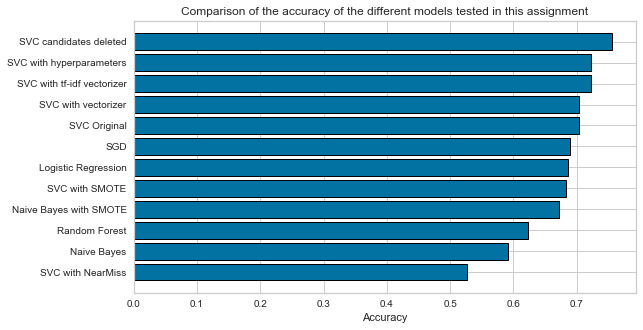

### Using our model to predict an author

One of the main interests of creating a Machine Learning model is to be able to do some prediction on new data. This is why we decided to save the Linear SVC model run on the 11 candidates described in 4.d. The *clean_input* function will ask you for a tweet to classify and give its guess about who the author of this tweet was.

For instance, you can try with the [following tweet](https://twitter.com/benoithamon/status/1132002896470532096) written by Benoît Hamon on the 24th of May 2019:

> *Nous travaillons à l’émergence d’une internationale de gauche et écologiste face à l’internationale raciste et l’internationale capitaliste. L’Europe et sa construction constitueront un appui. Et nos alliances seront claires : avec nous, pas d’alliance avec Macron et les libéraux*

You just need to run the next code block, and copy and paste the text above in the input cell, and press Enter. You will get the algorithm's classification. You can run this function again as many times as needed.

In [95]:
guess_model = pickle.load(open("data/guess_model.sav", 'rb'))
mm.clean_input(guess_model)

Please type a tweet to test our ML algorithm: 
Nous travaillons à l’émergence d’une internationale de gauche et écologiste face à l’internationale raciste et l’internationale capitaliste. L’Europe et sa construction constitueront un appui. Et nos alliances seront claires : avec nous, pas d’alliance avec Macron et les libéraux

I'd say it was tweeted by Benoit Hamon ?


# Other Information

&emsp;&emsp;All the previous parts were mostly directed at using different Machine Learning tasks to create clusters or solve classification problems. However, our attention could only be focused at one side of our data. Here, we will try to see if there are other information hidden in these data which could prove relevant or interesting.

## Me, Us and Them!

&emsp;&emsp;One of the information we thought might reveal interesting was to count the amount of reference for each candidate based on specific self-related concepts. Namely, we wanted to investigate the amount of times each candidate used self-references, other-related references, or references to a "we", that is "I" as a group or a community during the campaign. This information is contained in the graph below.

Text(0, 0.5, '')

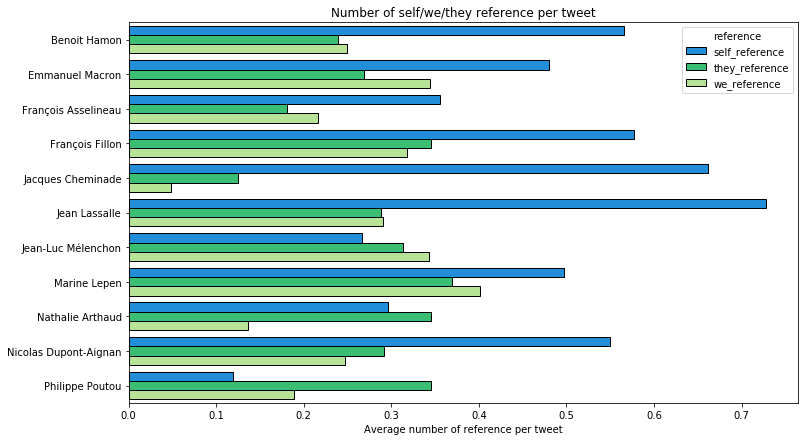

&emsp;&emsp;As shown on the graph above, the candidates who mostly used self-references during this campaign were Jean Lassalle, followed by Jacques Cheminade and François Fillon. Usually, self-references were more common than "we" or "they" references in the tweets. The only candidates for whom this pattern was not obvious were Philippe Poutou, Nathalie Arthaud and Jean-Luc Mélenchon, who preferred to use "they" or "we" references. This might be probably because each of them represented an opposition party, which could be distinguished, or need to be distinguished, by marking the difference between the people represented by these parties and the other candidates.

## I tweeted... I'm elected ?

&emsp;&emsp;Another metrics we thought might reveal interesting was to see if the amount of tweets ran during the campaign were associated with the score at the end of the first turn of the elections. One of the main issues with computing this correlation is the low sample size. Here, we try to compare 11 scores with 11 tweet counts (one for each candidate). However, we will run a power analysis afterwards to analyze the probability for our test to reject the null hypothesis when the alternative is true.

Correlation between voters and number of tweets: 0.8039640104666989 .
Significance level: 0.002859935992896172 .
Effect size: 0.8966404019821429


Text(0.5, 1.0, 'Correlation plot\n')

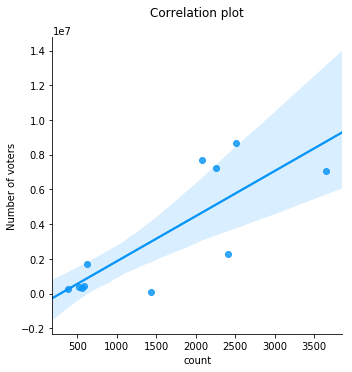

&emsp;&emsp;The plot above clearly shows a positive correlation between the amount of tweets and the score at the end of the first turn of the French presidential elections in 2017 (r = 0.804). Using G-Power, we computed the achieved power of the correlation test. The calculated power of our analysis was 0.9920529, which is a high statistical power achieved by the test. This means that there is a very low chance for a type II error (rejecting the alternative, when it is true). Therefore, despite the low sampled data, we can conclude there seems to be a link between both variables.

## The Twitter Chicken Run

Finally, we decided to see the evolution of the amount of tweets in time. First of all, the first graph describes the amount of tweets realized by all the candidates since 2010.

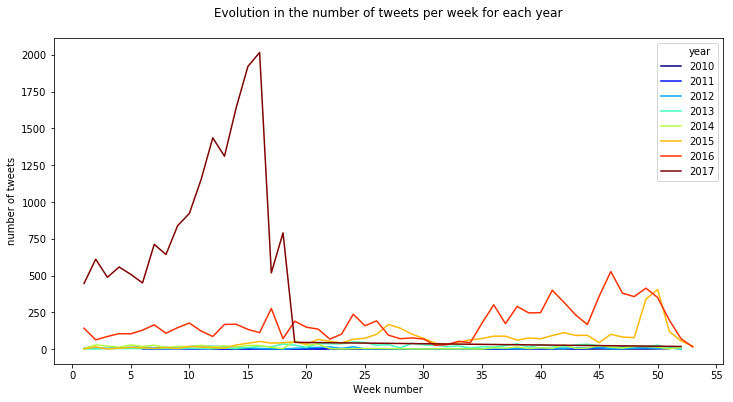

&emsp;&emsp;As the plot above clearly shows, we can easily see the difference in activity before and during the election, as well as the candidates preparation for the presidential election in 2016. Therefore, this graph clearly shows when an election is prepared on social media, which is about 9 months before the election (near week 35), and when are the most important moments in the election with a peak during the last 2 weeks before the end of the election (on week 17).

Next, we refined this analysis by plotting the cumulated sum of tweets per week per candidate.

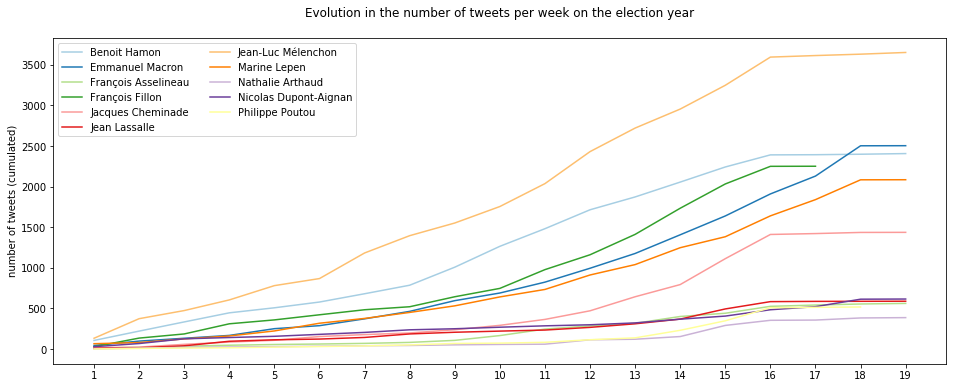

&emsp;&emsp;In order to fully understand this graph, one must remind the flatter the line, least tweets posted. This is pretty interesting as there is a clear cut between candidates who went to the secund turn of the election, who kept posting, and the others who just stopped tweeting after they had lost. This plot also allows us to distinguish candidates who posted most during this campaign, such as Jean-Luc Mélenchon and Benoît Hamon, but stopped tweeting after a while. Meanwhile, Emmanuel Macron, the current French president and winner of this campaign, mostly became active in the last few weeks before the end of the last turn, with Marine Lepen, his former contestant, displaying the almost exact same pattern during this period.

# Bibliography

Akbani, R., Kwek, S., & Japkowicz, N. (2004, September). Applying support vector machines to imbalanced datasets. In *European conference on machine learning* (pp. 39-50). Springer, Berlin, Heidelberg.<br>
Castro, A., & Lindauer, B. (2012). Author Identification on Twitter. <br>
Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. *Journal of artificial intelligence research*, *16*, 321-357.